# 8- MÉTRICAS

 La rápida expansión de NILM y el desarrollo de diferentes algoritmos, han hecho que sea esencial proporcionar una evaluación de rendimiento mediante el uso de métricas de desempeño. Las métricas de evaluación, comparan los resultados de la desagregaciónn (predicciones) de los modelos entrenados con los datos del set de validación (mediciones reales de cada proceso). NILMTK cuenta con el cálculo de métricas de evaluación mediante el uso del MeterGroup para la validación de los resultados mediante el set de validación 
 Vamos ahora analizar en nuestro dataset diferentes metricas como son FEAC,F1, EAE ,MNEAP y RMSE  que  resumimos a continuacion en el siguinte cuadro:

![metricas](metricas.jpg)

En primer lugar cargamos las ibrerías y realizamos otros ajustes:

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings
warnings. filterwarnings("ignore")
plt.style.use('bmh')

from nilmtk import TimeFrame, MeterGroup, HDFDataStore, DataSet
from nilmtk.metrics import fraction_energy_assigned_correctly, mean_normalized_error_power
from nilmtk.metrics import rms_error_power, f1_score, error_in_assigned_energy

data_dir='./data/'

### Métricas individuales del modelo

In [2]:
#Librerías
from nilmtk.metrics import f1_score
from nilmtk.metrics import error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power
from nilmtk.metrics import rms_error_power
from nilmtk.metrics import fraction_energy_assigned_correctly

In [3]:

labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})


 

#Set para validación
valid = DataSet('dsualmh.h5')
valid.set_window(start="2022-02-02 11:00:00", end="2022-02-02 12:00:00")
valid_elec = valid.buildings[1].elec

print('Medidor de cabecera para desagregación:')
valid_Main = valid_elec.mains()
print(valid_Main)

print('\nDispositivos para validación de entrenamiento:')
valid_Devices = valid_elec.select(instance=[2,3,4,5,6])
print(valid_Devices)




#Datos de Dispositivos: predicción
# Se carga los resultados del mejor modelo
#dataset=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
#predictions=dataset.buildings[1].elec.submeters()   





index = list(labels['Meters'][1:6])
met = []
e = []
#Datos de Dispositivos: predicción
dataset=DataSet(data_dir+'NILM/Results/FHMM_30s_first_pred.h5')
predictions=dataset.buildings[1].elec.submeters()      

#Metricas
f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {};

f1['F1'] = f1_score(predictions, valid_Devices)

EAE = error_in_assigned_energy(predictions, valid_Devices)

for x in range(len(EAE)): e.append(EAE.iloc[x][0])
eae['EAE'] = e
#da error esta medida AttributeError: 'tuple' object has no attribute 'instance'
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
#feac['FEAC'] = np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                      pd.DataFrame(f1),
                      pd.DataFrame(eae, index=valid_Devices.instance()),
                      pd.DataFrame(mneap),
                      pd.DataFrame(rmse)],
                     axis=1).set_index(pd.Index(index)))

dataset.store.close()       
print('\n\nDone!')
metrics=met[0].transpose().round(3)
metrics

Medidor de cabecera para desagregación:
ElecMeter(instance=1, building=1, dataset='dsualmh', site_meter, appliances=[])

Dispositivos para validación de entrenamiento:
MeterGroup(meters=
  ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='fan', instance=1)])
  ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='freezer', instance=1)])
  ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])
  ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])
  ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='boiler', instance=1)])
)


Done!


,fan,freezer,television,vacuum cleaner,boiler
F1,0.756,0.550,0.493,0.824,0.697
EAE,0.000,0.000,0.000,0.000,0.000
MNEAP,0.636,0.610,1.105,1.163,0.486
RMSE,920.526,22.118,40.123,28.247,394.057


Carga de datos de predicciones y GT en memoria

In [4]:
gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=30, resample_kwargs={'how':'first'})

labels = pd.DataFrame({'Instances': list(range(1,7)),
                       'Meters': ['main',  'fan', 'freezer', 'television','vacuum cleaner', 'boiler']})

Meters={}
for x in range(len(labels)): Meters[valid_elec[x+1]]=labels['Meters'][x]
    

    
    
#resultados de predicción modelo CO 30s
CO_30s_first=DataSet(data_dir+'NILM/Results/CO_30s_first_pred.h5')
elec_CO_30s_first=CO_30s_first.buildings[1].elec

#resultados de predicción modelo FHMM 30s
FHMM_30s_first=DataSet(data_dir+'NILM/Results/FHMM_30s_first_pred.h5')
elec_FHMM_30s_first= FHMM_30s_first.buildings[1].elec    
    
    

gt.columns=list(Meters.values())
pred_CO=elec_CO_30s_first.dataframe_of_meters(ac_type='active')

pred_CO.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

pred_FHMM=elec_FHMM_30s_first.dataframe_of_meters(ac_type='active')

pred_FHMM.columns=[list(Meters.values())[0]]+list(Meters.values())[1:6]

### Análisis particular del cálculo de cada métrica

Metrica FEAC ( da problema con AttributeError: 'tuple' object has no attribute 'instance')

In [5]:
#Carga de datos de predicciones y GT en memoria
#gt=valid_elec.dataframe_of_meters(ac_type='active', sample_period=60, resample_kwargs={'how':'first'})
#gt.columns=list(Meters.values())

In [6]:
#predictions_Devices=elec_CO_60s_first.submeters()

#frac_1 = valid_Devices.fraction_per_meter()
#frac_2 = predictions_Devices.fraction_per_meter()
#fig, (ax1, ax2) = plt.subplots(1, 2 ,gridspec_kw={'hspace': 0.1, 'wspace': 0.1})

#frac_1.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax1,   colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan'])
#frac_2.plot(autopct=lambda p:'{:.0f}%'.format(p), kind='pie',  labels=list(Meters.values())[1:6], figsize=(8,8), ax=ax2,  colors=['tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']) 

#ax1.set(ylabel="")
#ax1.set(xlabel="GT")
#ax2.set(ylabel="")
#ax2.set(xlabel="Predictions")
#plt.savefig('./data/images/5.4_FEAC_CO_60s.svg', bbox_inches='tight', transparent=True)
#pass

## Métrica F1

Esta métrica mide la precisión o asertividad del modelo entrenado mediante el cálculo de la media armónica utilizando las métricas Precision y Recall. Estas métricas son calculadas internamente por NILMTK mediante la matriz de confusión, vease la ecuación de la figura siguiente.

![metricas](metricas.jpg)

Precision se entiende como la fracción de cortes de tiempo en los que se predijo correctamente que un proceso estaba activo, pero realmente se encontraba apagado. Por lo contrario, Recall hace referencia a la fracción de cortes de tiempo en los que se predijo correctamente que el dispositivo estaba encendido y realmente se encontraba encendido .

In [7]:
pd.DataFrame(metrics.loc['F1']).transpose()*100

,fan,freezer,television,vacuum cleaner,boiler
F1,75.6,55.0,49.3,82.4,69.7


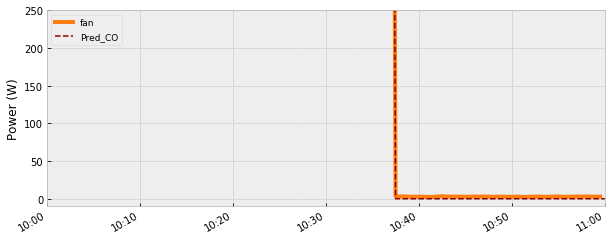

In [8]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 11:00:00+01:00' #tiempo inicial
t1='2022-02-02 12:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['fan'].plot(lw=4, c='tab:orange')
pred_CO['fan'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['fan','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')

#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))


plt.savefig('./data/images/5.5_F1_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

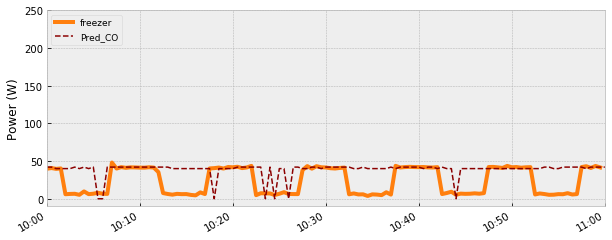

In [9]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 11:00:00+01:00' #tiempo inicial
t1='2022-02-02 12:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['freezer'].plot(lw=4, c='tab:orange')
pred_CO['freezer'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['freezer','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,250)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()
ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

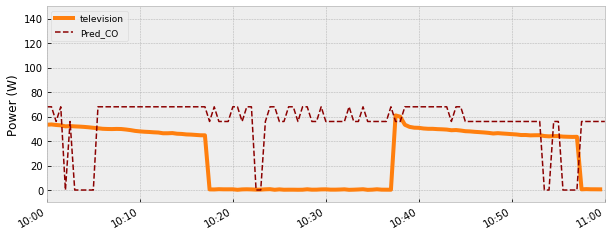

In [10]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 11:00:00+01:00' #tiempo inicial
t1='2022-02-02 12:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['television'].plot(lw=4, c='tab:orange')
pred_CO['television'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['television','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,150)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()

ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  
ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

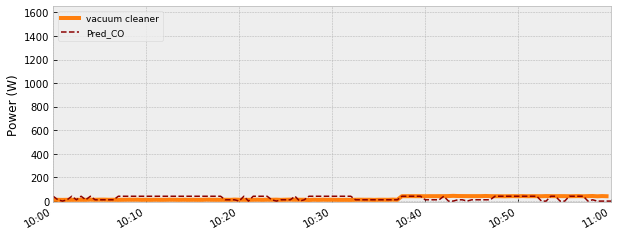

In [11]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 11:00:00+01:00' #tiempo inicial
t1='2022-02-02 12:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['vacuum cleaner'].plot(lw=4, c='tab:orange')
pred_CO['vacuum cleaner'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['vacuum cleaner','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,1650)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()

ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

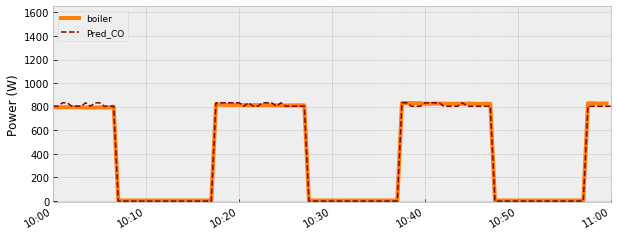

In [12]:
rcParams['figure.figsize'] = (10, 4)
t0='2022-02-02 11:00:00+01:00' #tiempo inicial
t1='2022-02-02 12:00:00+01:00' #tiempo final
fig, ax1 = plt.subplots();
ax1=gt['boiler'].plot(lw=4, c='tab:orange')
pred_CO['boiler'].plot(ax=ax1, c='darkred', lw=1.5, ls='--')
ax1.legend(labels=['boiler','Pred_CO'], fontsize=9, loc='upper left', ncol=1)
ax1.set_ylim(-10,1650)
ax1.set_xlim(t0,t1)
ax1.minorticks_off()

ax1.set_xticklabels(labels=['10:00','10:10','10:20','10:30','10:40','10:50','11:00','11:15'] , horizontalalignment ='right')  

ax1.set_ylabel('Power (W)')
#ax1.annotate('TP', xy=(250, 188), xycoords='figure points', xytext=(285, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('TN', xy=(320, 38), xycoords='figure points', xytext=(400, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FN', xy=(300, 38), xycoords='figure points', xytext=(530, 70), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
#ax1.annotate('FP', xy=(187, 188), xycoords='figure points', xytext=(220, 210), fontweight='bold',
#             arrowprops=dict(facecolor='red', width=3, headwidth=10))
plt.savefig('./data/images/5.5_F1_CO_60s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica EAE

La ecuación de la figura representa la diferencia entre la energía total asignada yˆt(n) energía total consumida yt(n) por el proceso n de la industria en kWh 

![metricas](metricas.jpg)

In [13]:
round(pd.DataFrame(metrics.loc['EAE']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
EAE,0.0,0.0,0.0,0.0,0.0


In [14]:
predictions_Devices=elec_CO_30s_first.submeters()
e1=predictions_Devices[5].total_energy()[0]
e2=valid_Devices[5].total_energy()[0]
eae=round(abs(e1-e2),2)

pd.DataFrame([e1,e2,eae], columns=['kWh'], index=['Energy_pred','Energy_GT','EAE'])

,kWh
Energy_pred,3.842637
Energy_GT,3.842637
EAE,0.000000


## Métrica MNEAP

Este indicador que representa la ecuacion de la imagen  consta de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) de cada proceso de la industria, por cada intervalo de tiempo t. Después de sumar todas las diferencias de potencia, el resultado es normalizado por el consumo total de la energía del proceso 

![metricas](metricas.jpg)

In [15]:
round(pd.DataFrame(metrics.loc['MNEAP']).transpose(),2)

,fan,freezer,television,vacuum cleaner,boiler
MNEAP,0.64,0.61,1.1,1.16,0.49


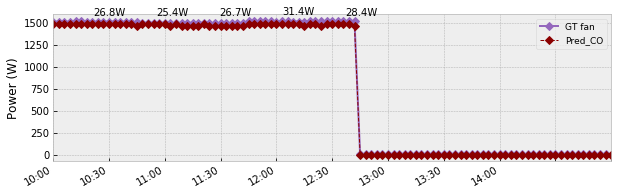

In [16]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['fan'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['fan'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT fan','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['fan'][a1[0]:a1[1]]-pred_CO['fan'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

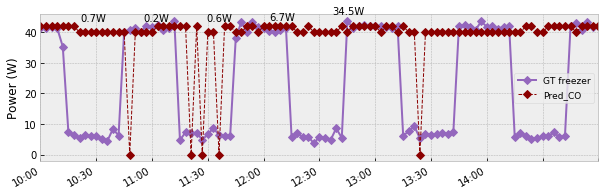

In [17]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['freezer'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['freezer'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT freezer','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['freezer'][a1[0]:a1[1]]-pred_CO['freezer'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

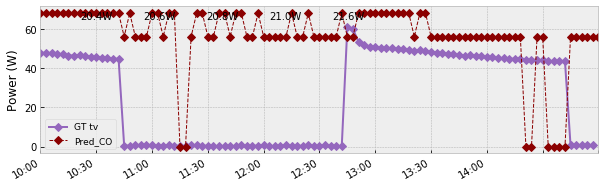

In [18]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['television'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['television'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT tv','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['television'][a1[0]:a1[1]]-pred_CO['television'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 130+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

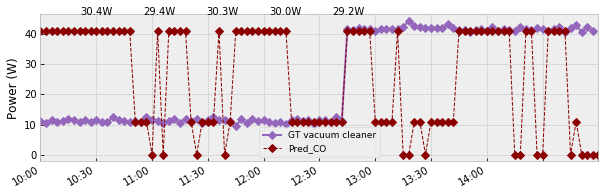

In [19]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['vacuum cleaner'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['vacuum cleaner'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT vacuum cleaner','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['vacuum cleaner'][a1[0]:a1[1]]-pred_CO['vacuum cleaner'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

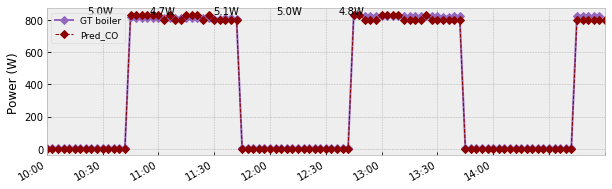

In [20]:
rcParams['figure.figsize'] = (10, 3)
fig, ax1 = plt.subplots();

#umbrales de potencia
a1=[20,1250]

gt['boiler'][a1[0]:a1[1]].plot(ax=ax1, lw=2, c='tab:purple', marker="D")
pred_CO['boiler'][a1[0]:a1[1]].plot(ax=ax1, c='darkred', lw=1, ls='--', marker="D")

ax1.minorticks_off()
ax1.set_ylabel('Power (W)')
ax1.legend(labels=['GT boiler','Pred_CO'], fontsize=9, ncol=1)

err= abs(round((gt['boiler'][a1[0]:a1[1]]-pred_CO['boiler'][a1[0]:a1[1]])[1:6],1))

aux=40
i=0
for e in err:
    ax1.annotate((str(err[i])+'W'), xy=(aux, 140+(abs(err[i]))*0.2), xycoords='axes points', size=10)
    aux=aux+63
    i=i+1


ax1.set_xticklabels(labels=['10:00','10:30','11:00','11:30','12:00','12:30','13:00','13:30','14:00',''])   
#plt.savefig('./data/images/5.6_MNEAP_CO_30s.svg', bbox_inches='tight', transparent=True)
pass

## Métrica RMSE

Esta métrica de la ecuación de la figura es muy utilizada en la comparaciónn de diversos conjuntos de datos, consiste en el error cuadrático medio de la diferencia entre la potencia asignada yˆt(n) y la potencia real yt(n) del proceso de los applicativos , en cada intervalo de tiempo t .

![metricas](metricas.jpg)

In [21]:
round(pd.DataFrame(metrics.loc['RMSE']).transpose(),1)

,fan,freezer,television,vacuum cleaner,boiler
RMSE,920.5,22.1,40.1,28.2,394.1


## Resultados de todos los modelos

In [22]:
from nilmtk.metrics import fraction_energy_assigned_correctly, f1_score, error_in_assigned_energy
from nilmtk.metrics import mean_normalized_error_power, rms_error_power 
periods = {'10s':10 , '30s':30, '60s':60, '5min':60*5, '10min':60*10, '15min':60*15, '30min':60*30}

dir_predictions = data_dir +'NILM/Results/'
m = {}
classifiers = ['CO', 'FHMM']
methods = ['first', 'mean', 'median']
index = list(labels['Meters'][1:6])

for p_name, sp in periods.items():
    met = []
    for method in methods:
        for clf_name in classifiers:
            print('\nCalculando Metricas: '+ clf_name + '_' + p_name + '_' + method)  
           
            #Datos de Dispositivos: predicción
            input_dir = dir_predictions + clf_name + '_' + p_name + '_' + method +'_pred.h5'
            dataset = DataSet(input_dir)
            predictions=dataset.buildings[1].elec.submeters()       
            
            #Metricas
            f1 = {}; eae = {}; feac = {}; mneap = {}; rmse = {}; e=[];  
            F1 = f1_score(predictions, valid_Devices)
            f1['F1'] = F1*100
            EAE = error_in_assigned_energy(predictions, valid_Devices)
            
            for x in range(len(EAE)): e.append(EAE.iloc[x][0])
            eae['EAE'] = e
            #da error para FEAC
            #feac['FEAC'] = 100*np.ones(6)*(fraction_energy_assigned_correctly(predictions, valid_Devices))
            mneap['MNEAP'] = mean_normalized_error_power(predictions, valid_Devices)
            rmse['RMSE'] = rms_error_power(predictions, valid_Devices)
            met.append(pd.concat([pd.DataFrame(feac, index=valid_Devices.instance()),
                                  pd.DataFrame(f1),
                                  pd.DataFrame(eae, index=valid_Devices.instance()),
                                  pd.DataFrame(mneap),
                                  pd.DataFrame(rmse)],
                                 axis=1).set_index(pd.Index(index)))
            dataset.store.close()        
    m[p_name] = met

##Guardamos resultados
f = open(data_dir +'NILM/metrics.txt',"w")
f.write( str(m) )
f.close()
print('\n\nDone!')



Calculando Metricas: CO_10s_first

Calculando Metricas: FHMM_10s_first

Calculando Metricas: CO_10s_mean

Calculando Metricas: FHMM_10s_mean

Calculando Metricas: CO_10s_median

Calculando Metricas: FHMM_10s_median

Calculando Metricas: CO_30s_first

Calculando Metricas: FHMM_30s_first

Calculando Metricas: CO_30s_mean

Calculando Metricas: FHMM_30s_mean

Calculando Metricas: CO_30s_median

Calculando Metricas: FHMM_30s_median

Calculando Metricas: CO_60s_first

Calculando Metricas: FHMM_60s_first

Calculando Metricas: CO_60s_mean

Calculando Metricas: FHMM_60s_mean

Calculando Metricas: CO_60s_median

Calculando Metricas: FHMM_60s_median

Calculando Metricas: CO_5min_first

Calculando Metricas: FHMM_5min_first

Calculando Metricas: CO_5min_mean

Calculando Metricas: FHMM_5min_mean

Calculando Metricas: CO_5min_median

Calculando Metricas: FHMM_5min_median

Calculando Metricas: CO_10min_first

Calculando Metricas: FHMM_10min_first

Calculando Metricas: CO_10min_mean

Calculando Metric

## Otras Metricas: métricas Promedio

In [23]:
m_mean = {}

#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']
labels=['CO-first', 'CO-mean', 'CO-median', 'FHMM-first', 'FHMM-mean' ,'FHMM-median']
per=['10s','30s','60s','5min','10min','15min','30min']

for c in cols:
    m_mean[c] = pd.DataFrame([#CO FIRST
                             [m['10s'][0][c].mean(),m['30s'][0][c].mean(),m['60s'][0][c].mean(),
                              m['5min'][0][c].mean(),m['10min'][0][c].mean(),
                              m['15min'][0][c].mean(),m['30min'][0][c].mean()],
                              #CO MEAN
                             [m['10s'][2][c].mean(),m['30s'][2][c].mean(),m['60s'][2][c].mean(),
                              m['5min'][2][c].mean(),m['10min'][2][c].mean(),
                              m['15min'][2][c].mean(),m['30min'][2][c].mean()],
                              #CO MEDIAN
                             [m['10s'][4][c].mean(),m['30s'][4][c].mean(),m['60s'][4][c].mean(),
                              m['5min'][4][c].mean(),m['10min'][4][c].mean(),
                              m['15min'][4][c].mean(),m['30min'][4][c].mean()],
                             #FHMM FIRST
                             [m['10s'][1][c].mean(),m['30s'][1][c].mean(),m['60s'][1][c].mean(),
                             m['5min'][1][c].mean(),m['10min'][1][c].mean(),
                              m['15min'][1][c].mean(),m['30min'][1][c].mean()],
                             #FHMM MEAN            
                             [m['10s'][3][c].mean(),m['30s'][3][c].mean(),m['60s'][3][c].mean(),
                              m['5min'][3][c].mean(),m['10min'][3][c].mean(),
                              m['15min'][3][c].mean(),m['30min'][3][c].mean()],
                             #FHMM MEDIAN
                             [m['10s'][5][c].mean(),m['30s'][5][c].mean(),m['60s'][5][c].mean(),
                              m['5min'][5][c].mean(),m['10min'][5][c].mean(),
                              m['15min'][5][c].mean(),m['30min'][5][c].mean()]],columns=per, index=labels).transpose()
m_mean


{'F1':         CO-first    CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s    84.576783  84.321015  83.072038   69.896304  69.737320    64.490626
 30s    80.999775  80.129660  82.858206   66.396953  63.643417    63.480419
 60s    77.885430  73.476526  77.797041   59.855890  61.936400    62.076960
 5min    0.000000   0.000000   0.000000   46.070175  46.070175    46.070175
 10min   0.000000   0.000000   0.000000   33.333333  33.333333    33.333333
 15min   0.000000   0.000000   0.000000   29.333333  29.333333    29.333333
 30min   0.000000   0.000000   0.000000   13.333333  13.333333    13.333333,
 'EAE':        CO-first  CO-mean  CO-median  FHMM-first  FHMM-mean  FHMM-median
 10s         0.0      0.0        0.0         0.0        0.0          0.0
 30s         0.0      0.0        0.0         0.0        0.0          0.0
 60s         0.0      0.0        0.0         0.0        0.0          0.0
 5min        0.0      0.0        0.0         0.0        0.0          0.0
 10min       

## Maximos


In [24]:
cols=['F1','EAE','MNEAP','RMSE']

maxs=pd.concat([m_mean['F1'].transpose().max(),
                m_mean['EAE'].transpose().min(),
                m_mean['MNEAP'].transpose().min(),
                m_mean['RMSE'].transpose().min()], axis=1)
maxs.columns=cols
maxs = maxs.transpose()
round(maxs,2)

,10s,30s,60s,5min,10min,15min,30min
F1,84.58,82.86,77.89,46.07,33.33,29.33,13.33
EAE,0.00,0.00,0.00,0.00,0.00,0.00,0.00
MNEAP,0.51,0.48,0.43,0.54,0.48,0.41,0.34
RMSE,33.56,33.84,29.80,226.92,190.99,167.29,174.22


## Correspondencia de Indice

In [25]:
cols=['F1','EAE','MNEAP','RMSE']

maxs_i=pd.concat([m_mean['F1'].transpose().idxmax(),
                 m_mean['EAE'].transpose().idxmin(),
                 m_mean['MNEAP'].transpose().idxmin(),
                 m_mean['RMSE'].transpose().idxmin()], axis=1)
maxs_i.columns=cols
maxs_i = maxs_i.transpose()
maxs_i

,10s,30s,60s,5min,10min,15min,30min
F1,CO-first,CO-median,CO-first,FHMM-first,FHMM-first,FHMM-first,FHMM-first
EAE,CO-first,CO-first,CO-first,CO-first,CO-first,CO-first,CO-first
MNEAP,CO-median,CO-median,CO-mean,FHMM-median,FHMM-mean,FHMM-mean,FHMM-median
RMSE,CO-mean,CO-median,CO-median,FHMM-first,FHMM-first,FHMM-first,FHMM-median


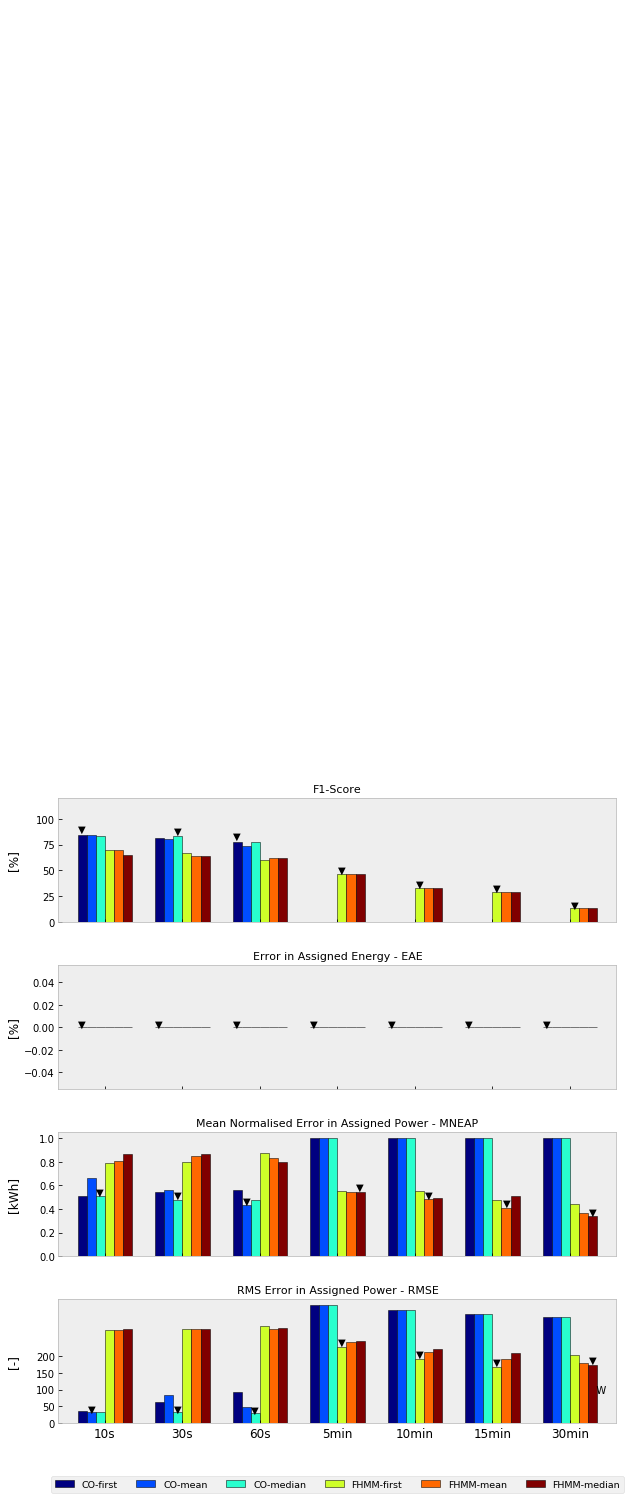

In [26]:
rcParams['figure.figsize'] = (10, 11.5)
fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=True, gridspec_kw={'hspace': 0.35})
cols=['F1','EAE','MNEAP','RMSE']
ylabels=['[%]','[%]','[kWh]','[-]','[W]']
per=['10s','30s','60s','5min','10min','15min','30min']

labels={'CO-first':-0.35, 'CO-mean':-0.22, 'CO-median':-0.11, 'FHMM-first':0.01, 'FHMM-mean':0.13 ,'FHMM-median':0.245}

c=0
for ax in fig.get_axes():      
    m_mean[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, cmap="jet")
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    x = 0
    for p in per:
        ax.annotate("▼", xy=(labels[maxs_i[p][cols[c]]]+x, maxs[p][cols[c]]+maxs[p][cols[c]]*0.03))
        x+=1
    c+=1
    
ax5.set_xticklabels(labels=per, rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax2,ax3,ax4,ax5)])
ax2.set(ylim=(0,120))
ax2.set_yticks([0,25,50,75,100])

ax5.set_yticks([0,50,100,150,200])

ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels.keys(), loc='lower center', ncol=6, bbox_to_anchor=(0.5, -0.6),fontsize=9.5)


#ax2.annotate("90.5%", xy=(0.68, 98)); #30s FHMM-mean
#ax3.annotate("0.19", xy=(6.22, 1.4)); #30min FHMM-median
ax3.annotate("kWh", xy=(6.22, 0.9)); #30min FHMM-median
#ax4.annotate("0.24", xy=(6.22, 0.7)); #30min FHMM-median
#ax5.annotate("41.5", xy=(6.22, 120)); #30min FHMM-median
ax5.annotate("   W", xy=(6.22, 90)); #30min FHMM-median


plt.savefig('./data/images/5.7_All_metrics.svg', bbox_inches='tight', transparent=True)

pass

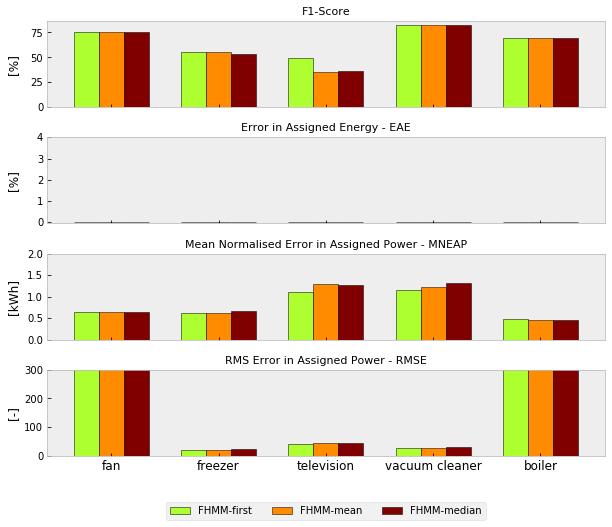

In [27]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})

#cols=['FEAC','F1','EAE','MNEAP','RMSE']
cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']
labels=['FHMM-first', 'FHMM-mean' ,'FHMM-median']
c=0

for ax in fig.get_axes():
    
    df=pd.DataFrame([m['30s'][1][cols[c]],m['30s'][3][cols[c]],m['30s'][5][cols[c]]]).transpose()
    #if ax==ax1:
    #    df['FEAC'].mean().plot.barh(ax=ax1, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    #else:
    #     df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
 
    df.plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False,   color=['greenyellow','darkorange','maroon'])
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1   
    

ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})
fig.align_ylabels([(ax1,ax2,ax3,ax4,ax5)])
ax3.set_yticks([0,1,2,3,4])
ax4.set(ylim=(0,1.8))
ax4.set_yticks([0,0.5,1,1.5,2])
ax5.set(ylim=(0,270))
ax5.set_yticks([0,100,200,300])
ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')
lgd = ax5.legend(labels, loc='lower center', ncol=3, bbox_to_anchor=(0.5, -0.8))


plt.savefig('./data/images/5.8_All_metrics_2.svg', bbox_inches='tight', transparent=True)

pass

In [28]:
print('FHMM-first')
print(m['30s'][1])
print('\nFHMM-mean')
print(m['30s'][3])
print('\nFHMM-median')
print(m['30s'][5])

FHMM-first
                       F1  EAE     MNEAP        RMSE
fan             75.647668  0.0  0.635643  920.525837
freezer         55.045872  0.0  0.609687   22.117529
television      49.275362  0.0  1.105363   40.123216
vacuum cleaner  82.352941  0.0  1.163119   28.246625
boiler          69.662921  0.0  0.486500  394.056857

FHMM-mean
                       F1  EAE     MNEAP        RMSE
fan             75.647668  0.0  0.644294  924.331421
freezer         55.357143  0.0  0.615828   21.763166
television      35.294118  0.0  1.303451   44.268984
vacuum cleaner  82.352941  0.0  1.215420   28.544713
boiler          69.565217  0.0  0.459025  379.772463

FHMM-median
                       F1  EAE     MNEAP        RMSE
fan             75.647668  0.0  0.636180  920.543876
freezer         53.097345  0.0  0.665308   23.144074
television      36.641221  0.0  1.269496   43.837948
vacuum cleaner  82.352941  0.0  1.306711   29.940262
boiler          69.662921  0.0  0.457305  382.741425


### Resultados del mejor modelo
En vista de los resultados del obtenidos, se propone la elección del modelo FHMM entrenado con datos promedio de dispositivos cada 10 minutos. Este modelo solo se considera adecuado para la desagregación de datos promedio de potencia activa medidos en cabecera cada 10 minutos.

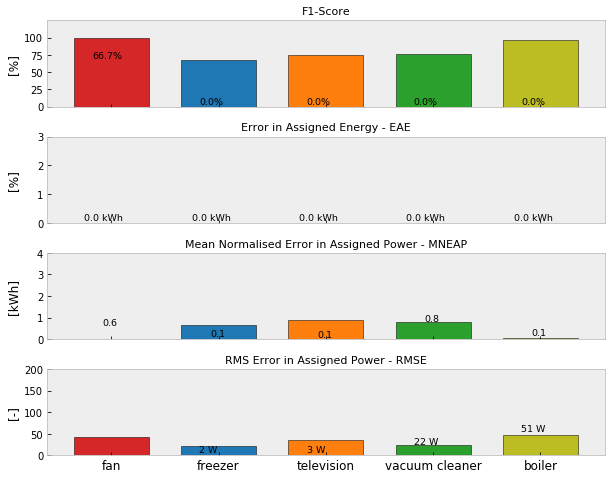

In [29]:
rcParams['figure.figsize'] = (10, 8)

fig, (ax2,ax3,ax4,ax5) = plt.subplots(4, 1, sharex=False, gridspec_kw={'hspace': 0.35})
#cols=['FEAC','F1','EAE','MNEAP','RMSE']

cols=['F1','EAE','MNEAP','RMSE']

ylabels=['[%]','[%]','[kWh]','[-]','[W]']
colors=['tab:red','tab:blue','tab:orange','tab:green','tab:olive','tab:purple','tab:cyan']
c=0

for ax in fig.get_axes():
    df=pd.DataFrame(m['30s'][4][cols[c]])
    df[cols[c]].plot.bar(ax=ax, width=0.7, edgecolor='black', linewidth=0.5, legend=False, color=colors)
    ax.set(ylabel=ylabels[c])
    ax.grid(b=None)
    c+=1


ax2.set_xticklabels('')
ax3.set_xticklabels('')
ax4.set_xticklabels('')
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=0, fontdict={'fontsize':12})

fig.align_ylabels([(ax2,ax3,ax4,ax5)])

ax2.set(ylim=(0,125))
ax3.set(ylim=(0,1))
ax4.set(ylim=(0,0.7))
ax5.set(ylim=(0,110))

ax2.set_yticks([0,25,50,75,100])
ax3.set_yticks([0,1,2,3])
ax4.set_yticks([0,1,2,3,4])
ax5.set_yticks([0,50,100,150,200])


ax2.set_title('F1-Score', fontsize=11, loc='center')
ax3.set_title('Error in Assigned Energy - EAE', fontsize=11, loc='center')
ax4.set_title('Mean Normalised Error in Assigned Power - MNEAP', fontsize=11, loc='center')
ax5.set_title('RMS Error in Assigned Power - RMSE', fontsize=11, loc='center')

df=pd.DataFrame(m['30min'][5])

for x in range(5):ax2.annotate(str(round(df['F1'][x],1))+'%', xy=(x-0.18 , df['F1'][x]+4),fontsize=9.5)
for x in range(5):ax3.annotate(str(round(df['EAE'][x],1))+' kWh', xy=(x-0.25 , df['EAE'][x]+0.1),fontsize=9.5)
for x in range(5):ax4.annotate(str(round(df['MNEAP'][x],1)), xy=(x-0.08 , df['MNEAP'][x]+0.03),fontsize=9.5)
for x in range(5):ax5.annotate(str(round(df['RMSE'][x]))+' W', xy=(x-0.18 , df['RMSE'][x]+5),fontsize=9.5)

plt.savefig('./data/images/5.9_Metrics_FHMM_30min_median.svg', bbox_inches='tight', transparent=True)

In [30]:
valid_Devices.total_energy()

Calculating total_energy for ElecMeterID(instance=6, building=1, dataset='dsualmh') ...   

apparent    26.212597
reactive     0.034004
active       1.416458
dtype: float64

In [31]:
valid_Devices.energy_per_meter()

5/5 ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='boiler', instance=1)])nce=1)])

,"(2, 1, dsualmh)","(3, 1, dsualmh)","(4, 1, dsualmh)","(5, 1, dsualmh)","(6, 1, dsualmh)"
active,0.930978,0.023868,0.030272,0.022803,0.408538
apparent,NaN,NaN,NaN,NaN,NaN
reactive,NaN,NaN,NaN,NaN,NaN


### Replicando el entrenamiento del modelo

In [32]:
from nilmtk import DataSet
from nilmtk.legacy.disaggregate import FHMM


train = DataSet('dsualmh.h5')

train.set_window(start="2022-02-02 12:00:00", end="2022-02-02 12:58:00")
train_elec=train.buildings[1].elec 

#dispositivos a entrenar: [Lights_1, Lights_2, HVAC_1, HVAC_2, HVAC_4, Rack]
train_Devices=train_elec.select(instance=[2,3,4,5,6])

#opcional: asignación manual de estados de dispositivos
num_states={train_Devices[2]:2, train_Devices[3]:3, train_Devices[4]:4,
            train_Devices[5]:5, train_Devices[6]:6}

#entrenamiento y exportación del modelo
FHMM_30s_median=FHMM()
FHMM_30s_median.MIN_CHUNK_LENGTH=1
FHMM_30s_median.train(train_Devices,
                        num_states_dict={}, #en otro caso: { }
                        ac_type='active',
                        sample_period=1800,
                        resample_kwargs={'how':'median'})


#falla aqui al exportar el modelo
#FHMM_30min_median.export_model('./data/FHMM_30s_median_model.pickle') 
#output=HDFDataStore(data_dir+'NILM/Results/'+model_name+'_'+sp_name+'_'+method+'_pred.h5', 'w')


print('\n\nDone!')


Training model for submeter 'ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='fan', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='freezer', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)])' with 1 states
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='boiler', instance=1)])' with 1 states


Done!


In [33]:
from nilmtk.legacy.disaggregate import FHMM
FHMM=FHMM()
#FHMM.import_model('C:/data/FHMM_30min_median_model.pickle') 
print('Fan: '+str(FHMM_30s_median.individual[valid_Devices[2]].means_))
print('Freezer: '+str(FHMM_30s_median.individual[valid_Devices[3]].means_))
print('Television: '+str(FHMM_30s_median.individual[valid_Devices[4]].means_))
print('Vacuum Cleaner: '+str(FHMM_30s_median.individual[valid_Devices[5]].means_))
print('Boile: '+str(FHMM_30s_median.individual[valid_Devices[6]].means_))


Fan: [[2.69121599]]
Freezer: [[8.4273243]]
Television: [[0.4752062]]
Vacuum Cleaner: [[25.87575912]]
Boile: [[413.45390558]]


In [34]:
FHMM_30s_median.model

GaussianHMM(covariance_type='full')

In [35]:
FHMM_30s_median.individual

OrderedDict([(ElecMeter(instance=2, building=1, dataset='dsualmh', appliances=[Appliance(type='fan', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=3, building=1, dataset='dsualmh', appliances=[Appliance(type='freezer', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=4, building=1, dataset='dsualmh', appliances=[Appliance(type='television', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=5, building=1, dataset='dsualmh', appliances=[Appliance(type='vacuum cleaner', instance=1)]),
              GaussianHMM(covariance_type='full')),
             (ElecMeter(instance=6, building=1, dataset='dsualmh', appliances=[Appliance(type='boiler', instance=1)]),
              GaussianHMM(covariance_type='full'))])